This is an extention of both the varying intercept example with tadpoles in ponds and the logistic regression example with chimps pulling levers. Firstly, a varying intercept may be added to the chimp model to take the partial-pooling approach to modeling inter-dependant model intercepts for each chimp. This should be a more suitable option than the complete-pooling and no-pooling approaches explored in ../interation/logistic_reg.ipynb.

Secondly, to explore the idea of multiple varying intercepts, a varying intercept will be added to capture the influence of different level pull trial blocks - one trial block represents trials conducted on the same day with the same food options, same weather etc... 

l ~ binomial( 1, prob )
prob ~ logistic( alpha + alphaActor[i] + alphaBlock[j] + ( betaP + betaPC*C )*P )
alphaActor ~ normal( 0, sigmaActor )
alphaBlock ~ normal( 0, sigmaBlock )

Note the new formulation for setting up a model with multiple varying intercepts. Importantly the distributions for all varying intercepts must be centered at zero! Multiple non-zero intercept centers would all be linearly combined and indistiguishable, so the model would be unable to fit them. There must be only one global mean parameter, alpha.

As with the tadpoles example, the fitted values for sigmaActor and sigmaBlock will capture the degree of pooling across clusters.

In [1]:
import numpy as np
import stan
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
# work around to get stan working in a notebook
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [2]:
df = pd.read_csv('../datasets/chimps.csv',sep=';')
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [3]:
df['actor'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [6]:
df['block'].unique()

array([1, 2, 3, 4, 5, 6])

In [39]:
model = '''
data {
    int<lower=1> N;
    int<lower=1> A;     // number of actors
    int<lower=1> B;     // number of blocks
    int<lower=0, upper=1> l[N];
    int<lower=0,upper=1> c[N];
    int<lower=0,upper=1> p[N];
    int<lower=1,upper=A> a[N];
    int<lower=1,upper=B> b[N];
}
parameters {
    real alpha;
    real betaP;
    real betaPC;

    vector[A] alphaActor;
    vector[B] alphaBlock;

    real<lower=0> sigmaActor;
    real<lower=0> sigmaBlock;
}
model {
    alpha ~ normal(0,10);
    betaP ~ normal(0,10);
    betaPC ~ normal(0,10);
    
    sigmaActor ~ cauchy(0,1);
    sigmaBlock ~ cauchy(0,1);

    alphaActor ~ normal(0,sigmaActor);
    alphaBlock ~ normal(0,sigmaActor);

    for (n in 1:N) {
        l[n] ~ binomial(1, inv_logit( alpha + alphaActor[ a[n] ] + alphaBlock[ b[n] ] + (betaP + (betaPC * c[n])) * p[n]) ); 
    }
}
'''
posterior = stan.build(program_code=model,data={
    "N" : len(df['pulled_left'].to_list()),
    "A" : df['actor'].max(),
    "B" : df['block'].max(),
    "l" : df['pulled_left'].to_list(),
    "c" : df['condition'].to_list(),
    "p" : df['prosoc_left'].to_list(),
    "a" : df['actor'].to_list(),
    "b" : df['block'].to_list()

})
fit = posterior.sample(num_chains=4, num_warmup=1000, num_samples=6000)
az_fit = az.from_pystan(posterior=fit,
                        posterior_model=posterior,
                        observed_data="l")

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/httpstan_n51pvpt5/model_d3ujyvfo.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/httpstan_n51pvpt5/model_d3ujyvfo.stan', line 7, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/httpstan_n51pvpt5/model_d3ujyvfo.stan', line 8, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will b

array([[<Axes: title={'center': 'sigmaBlock'}>,
        <Axes: title={'center': 'sigmaBlock'}>],
       [<Axes: title={'center': 'sigmaActor'}>,
        <Axes: title={'center': 'sigmaActor'}>]], dtype=object)

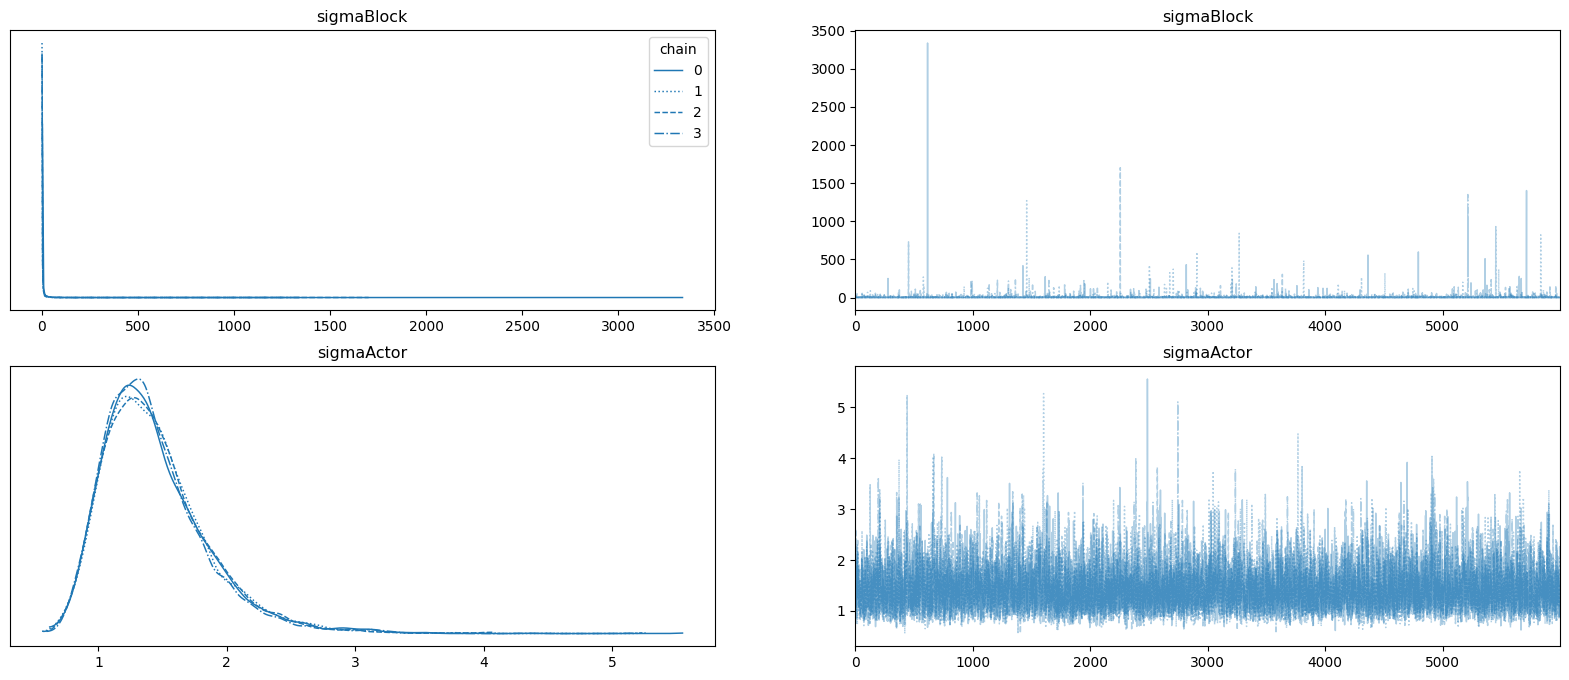

In [40]:
az.plot_trace(az_fit, ["sigmaBlock","sigmaActor"], figsize=(20,8), legend=True)

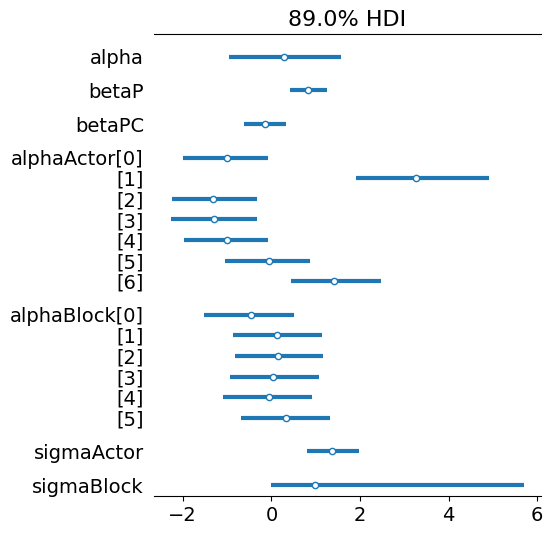

In [46]:
axes = az.plot_forest(az_fit,
                           kind='forestplot',
                           combined=True,
                           quartiles=False,
                           hdi_prob=0.89,
                           figsize=(5, 6))